# Prototype Code for Data Generation and Simulation

Importing libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

### Data generation and sampling

We define a class named CustomData that generates the entire dataset and can return batches of data upon request during the simulation.

In [2]:
class CustomData:
    """
    CustomData class generates the entire data set and can return samples
    """
    def __init__(self,n_samples=1000,n_features=20,n_informative=8):
        """
        Parameters
        ----------
        n_samples: number of samples to be generated
        n_features: number of all possible features
        n_informative: number of features the model is based on
        """
        self._n_samples = n_samples
        self._n_features = n_features
        self._n_informative = n_informative
        self._n_targets = 1
        self._bias = 1
        self._effective_rank = 20
        self._tail_strength = 0.7
        self._noise = 0.1
        self._shuffle = True
        self._coef = True
        self._random_state = 42
        self._X, self._y, self._model = make_regression(self._n_samples,
                                                       self._n_features,
                                                       self._n_informative,
                                                       self._n_targets,
                                                       self._bias,
                                                       self._effective_rank,
                                                       self._tail_strength,
                                                       self._noise,
                                                       self._shuffle,
                                                       self._coef,
                                                       self._random_state)
        self._collected = 0
        index = range(1,self._n_samples+1)
        columns = ["feature {}".format(i) for i in range(1,self._n_features+1)] + ["labels"]
        self._complete_data = pd.DataFrame(np.c_[self._X,self._y], index, columns)
    
    def collect(self,n_instances,feature_list=0):
        """
        Returns some data
        Parameters
        ----------
        n_instances: number of collected instances
        feature_list: a list of features that are to be collected
        Returns
        X: X-matrix containing the values corresponding each instance and selected feature
        y: y-vector containing the labels of each instance
        -------
        """
        if feature_list==0:
            feature_list = range(1,self._n_features+1)
        if self._collected + n_instances > self._n_samples:
            print("Not enough samples to collect {} instances. Try a lower number of instances.".format(n_instances))
            print("Returning 0-by-|feature_list| X and 0-by-1 y.")
            return np.empty(shape=(0,len(feature_list))), np.empty(shape=(0,1))
        X = self._complete_data[["feature {}".format(i) for i in feature_list]][self._collected:self._collected+n_instances].copy()
        y = self._complete_data[["labels"]][self._collected:self._collected+n_instances].copy()
        self._collected += n_instances
        return np.array(X), np.array(y)
    
    def reset_collection(self):
        """
        Resets number of collected instances, useful when using same dataset again
        """
        self._collected = 0

### Computing correlations

Following functions are defined to compute correlation matrices and vectors for input data and labels.

In [3]:
def get_correlation_matrix(X,y):
    """
    Get correlation matrix for the given data instances X, and outputs y
    Parameters
    ----------
    X: Input data X
    y: Labels y
    Returns
    -------
    corr_matrix: correlation matrix for each (feature,feature) and (feature,label) pair
    """
    index = range(1,X.shape[0]+1)
    n_features = X.shape[1]
    columns = ["feature {}".format(i) for i in range(1,n_features+1)] + ["labels"]
    data = pd.DataFrame(np.c_[X,y], index, columns)
    corr_matrix = data.corr()
    return corr_matrix

In [4]:
def get_correlation_vec(X,y):
    """
    Get correlation vector between features of X and the labels y
    Parameters
    ----------
    X: Input data X
    y: Labels y
    Returns
    -------
    corr_vec: correlation vec (feature,label) pair
    """
    index = range(1,X.shape[0]+1)
    n_features = X.shape[1]
    columns = ["feature {}".format(i) for i in range(1,n_features+1)] + ["labels"]
    data = pd.DataFrame(np.c_[X,y], index, columns)
    corr_matrix = data.corr()
    corr_vec = corr_matrix["labels"].sort_values(ascending=False)
    return corr_vec

### Simulation

Following is a function prototype for feature selection, that returns a list of features depending on the input parameters. To compute the reward for each feature, we use a formulation inspired from Upper-Confidence-Bound Action Selection(Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.) $J$ is the value of each feature, $c$ is the trade-off factor for exploitation and exploration, step represents the time, $N$ is the number of samples collected for each feature, feature limit is the number of features that is desired to be collected.

$N$ is initialized to be a vector of 1's. $N$ includes the samples whose features are determined but values are not collected yet. This algorithm accounts for the features that are selected in the previous step but are still pending for data.

Additionally, $\epsilon$-greedy selection is implemented for further exploration.

In [5]:
def feature_selection(J,c,step,N,feature_limit):
    """
    Selects and returns optimal features
    Parameters
    ----------
    J: Value vector for features
    c: Trade-off factor (exploitation vs. exploration)
    step: Current time (t)
    N: Number of samples collected for each feature (including previously selected features that are to be collected)
    feature_limit: desired number of features to be selected
    Returns
    -------
    feature_list: a list of selected features
    """
    feature_list = list()
    reward = list()
    n_features = len(J)
    unselected_features = list(range(1,n_features+1))
    eps = 0.01
    for feature in range(1,n_features+1):
        if N[feature-1] == 0:
            reward.append(np.infty)
        else:
            reward.append(J[feature-1] + c*np.sqrt(np.log(step+1)/N[feature-1]))
    while len(feature_list) < feature_limit:
        greedy_feature = greedy_selection(reward)
        random_feature = random_selection(unselected_features)
        
        selected_feature = np.random.choice([greedy_feature, random_feature], p=[1-eps, eps])
        feature_list.append(selected_feature)
        reward[feature_list[-1]-1] = -1*np.infty
        unselected_features.remove(feature_list[-1])
        
    return feature_list

Following function prototype selects a greedy feature using the list of rewards, resulting in the maximum possible reward.

In [6]:
def greedy_selection(reward_list):
    """
    Return a greedy selection using list of rewards
    Parameters
    ----------
    reward_list: list of rewards
    Returns
    -------
    greedy_feature: greedily selected feature resulting in maximum reward
    """
    greedy_feature = int(np.argmax(reward_list))+1
    return greedy_feature

Following function prototype selects a random feature among unselected features for the purpose of exploration.

In [7]:
def random_selection(unselected_features):
    """
    Return a random selection from unselected features
    Parameters
    ----------
    unselected_features: list of unselected features
    Returns
    -------
    random_feature: randomly selected feature for exploration purpose
    """
    random_feature = np.random.choice(unselected_features)
    return random_feature

Following is a function prototype that adds collected data from the current batch to the memory. Note that $X_{memo}$ has a shape of $n_{samples} \times n_{features}$. Therefore, only collected features will have non-zero entries when the sampled data is being transferred to memory.

In [8]:
def add_to_memory(X_memo, X_batch, y_memo, y_batch, selected_features):
    """
    Add collected batch of data to memory
    Parameters
    ----------
    X_memo: current X-matrix in memory
    X_batch: collected data X
    y_memo: current y-vector in memory
    y_batch: assigned labels y
    selected_features: features that the collected data X is based on
    Returns
    -------
    X_memo: updated X-matrix in memory
    y_memo: updated y-vector in memory
    """
    X_append = np.zeros((X_batch.shape[0],X_memo.shape[1]))
    y_append = np.zeros((y_batch.shape[0],y_memo.shape[1]))
    idx = 0
    for feature in selected_features:
        X_append[:,feature-1] = X_batch[:,idx]
        idx += 1
    y_append = y_batch
    X_memo = np.concatenate((X_memo, X_append))
    y_memo = np.concatenate((y_memo, y_append))
    return X_memo, y_memo

Following function is used to keep track of the steps that samples from each feature is collected. It helps with accessing the corresponding samples (necessary in computing/estimating $J$)

In [9]:
def update_memory_track(memory_track,selected_features,step):
    """
    Updates memory track list depending on the selected features in the given step
    Parameters
    ----------
    memory_track: list that stores the steps each feature is collected
    selected_features: list of features selected in current step
    step: number of current step
    Returns
    -------
    memory_track: list updated with the current step information
    """
    for feature in selected_features:
        memory_track[feature-1].append(step)
    return memory_track

Following is a function prototype for computing the feature values given the data in memory, features selected in current step and the regressor.

Computation of $J$ is currently based on the correlation value between each feature and the label. In addition to the collected data in memory, we generate some dummy data for the features selected in current time step and label them using the predictor (current regression model).

In [10]:
def update_J(X_memo, y_memo, selected_features, memory_track, n_vehicles, regressor, estimation=True):
    """
    Computes feature values J
    Parameters
    ----------
    X_memo: current X-matrix in memory
    y_memo: current y-vector in memory
    selected_features: list of features selected in current step
    memory_track: list that stores the steps each feature is collected
    n_vehicles: number of vehicles from which data is collected at each step (batch size)
    regressor: current regressor object
    estimation: boolean value for whether to use estimation
    Returns
    -------
    J: list of computed feature values
    """
    dummy_X_memo = np.copy(X_memo)
    dummy_y_memo = np.copy(y_memo)
    if estimation:
        dummy_X_batch = np.zeros((n_vehicles,X_memo.shape[1]))
        for feature in selected_features:
            steps = memory_track[feature-1]
            samples = list()
            for step in steps:
                for point in X_memo[step*n_vehicles:(step+1)*n_vehicles,feature-1]:
                    samples.append(point)
            for vehicle in range(0,n_vehicles):
                if len(samples) == 0:
                    dummy_X_batch[vehicle,feature-1] = 0
                else:
                    dummy_X_batch[vehicle,feature-1] = np.random.choice(samples)

        dummy_y_batch = regressor.predict(dummy_X_batch).reshape(n_vehicles,1)
        dummy_X_memo = np.concatenate((dummy_X_memo, dummy_X_batch))
        dummy_y_memo = np.concatenate((dummy_y_memo, dummy_y_batch))
    else:
        pass
    
    corr_measure = get_correlation_vec(dummy_X_memo, dummy_y_memo)
    J = list()
    for i in range(1,X_memo.shape[1]+1):
        key = 'feature {}'.format(i)
        if np.isnan(corr_measure[key]):
            J.append(0)
        else:
            J.append(abs(corr_measure[key]))
    return J

Following is a function prototype for updating the number of samples collected for each feature.

In [11]:
def update_N(N, selected_features, n_instances):
    """
    Updates sample numbers N for each feature
    Parameters
    ----------
    N: current number of samples of each feature
    selected_features: selected features that require an update
    n_instances: collected number of samples that are to be added
    Returns
    -------
    N: updated list of sample numbers for each feature
    """
    for feature in selected_features:
        N[feature-1] += n_instances
    return N

Following function prototype simulates a given step of feature selection and data collection procedures. Then it returns the feature value vector $J$, trained regressor and stored vectors of $J$ through each step.

We initialize $X_{memo}$ and $y_{memo}$ as empty matrix and vector, $J$ is initialized to zeros and $N$ is initialized to ones. Trade-off factor is selected as 2. A collection queue is initialized to store the selected features in order of data collection. Memory track list stores the step numbers in which samples are collected for each feature.

For given number of steps, we select features depending on the feature values $J$, trade-off factor $c$, current step number $step$, number of samples collected for each feature $N$, and the number of features to be selected $feature\_limit$ (defaulted at 5). Then we update the $memory\_track$. First item from the collection queue is removed and selected features are appended to queue. We update $J$ using the already collected data and if estimation parameter is set to True also using information on currently selected features. Number of samples $N$ is updated using the most recently selected features. Then, we collect data using the next subset of features in queue (assuming that there is a delay between the feature selection process and the collection of data, we can only collect data using the features in queue). Collected data is added to memory, and regression model is trained using the data in memory.

In [12]:
def simulate_procedure(dataset,regressor,n_steps=100,n_vehicles=100,feature_limit=5,collection_delay=3,estimation=True):
    """
    Simulates gradual data collection procedure
    dataset: entire dataset including all future data
    regressor: input regressor object (linear regression)
    n_steps: number of steps
    n_vehicles: number of vehicles to collect data from
    feature_limit: desired number of features to be selected
    collection_delay: specifies the number of steps after which data is collected on selected features
    estimation: boolean value for whether to use estimation when computing J
    Returns
    -------
    J: list of computed feature values
    regressor: trained regressor
    J_rec: recorded array of evolution of feature values
    """
    X_memo = np.empty(shape=(0,dataset._n_features))
    y_memo = np.empty(shape=(0,1))
    J = np.zeros((dataset._n_features,1))
    N = np.ones((dataset._n_features,1))
    c = 2
    collection_queue = [list() for i in range(0,collection_delay)]
    memory_track = [list() for i in range(0,dataset._n_features)]
    J_storage = list()
    for step in range(n_steps):
        selected_features = feature_selection(J,c,step,N,feature_limit)
        memory_track = update_memory_track(memory_track,selected_features,step)
        current_features = collection_queue.pop(0)
        collection_queue.append(selected_features)
        J = update_J(X_memo, y_memo, selected_features, memory_track, n_vehicles, regressor, estimation)
        N = update_N(N,selected_features, n_vehicles)
        X_batch, y_batch = dataset.collect(n_vehicles,current_features)
        X_memo, y_memo = add_to_memory(X_memo, X_batch, y_memo, y_batch, current_features)
        regressor.fit(X_memo, y_memo)
        J_storage.append(J)
        
    J_rec = np.array(J_storage)
    return J,regressor,J_rec

Following function initializes a given type of regressor and trains it with dummy data (so that it can be used in the simulation for the first time).

In [13]:
def initialize_regressor(n_features):
    """
    Initializes linear regressor with dummy training
    Parameters
    ----------
    n_features: number of features required for dummy training set
    Returns
    -------
    reg: initialized and dummily trained regressor
    """
    
    reg = LinearRegression()
    reg.fit(np.zeros((2,n_features)),np.zeros((2,)))
    
    return reg

Following function is used to plot evolution of feature values $J$ over simulation steps.

In [14]:
def plot_J(J_rec):
    """
    Plots the evolution of feature values J through simulation steps
    Parameters
    ----------
    J_rec: array, storing J-vectors through simulation steps
    """
    for i in range(0,J_rec.shape[1]):
        plt.plot(J_rec[:,i],label="feature {}".format(i+1))
    
    plt.xlabel("Step")
    plt.ylabel("J")
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.legend()
    plt.show()

Entire dataset consisting of 1000000 instances is generated as follows, with 20 features (8 of which are informative).

In [15]:
dataset = CustomData(n_samples=1000000, n_features=20, n_informative=8)

Below we carry out the simulation with `estimation=True` and `estimation=False`.

Approach 1: Using estimation for computing J to account for the selected but not collected features

In [16]:
reg_1 = initialize_regressor(dataset._n_features)
J_1, reg_1, J_rec_1 = simulate_procedure(dataset,reg_1,estimation=True)

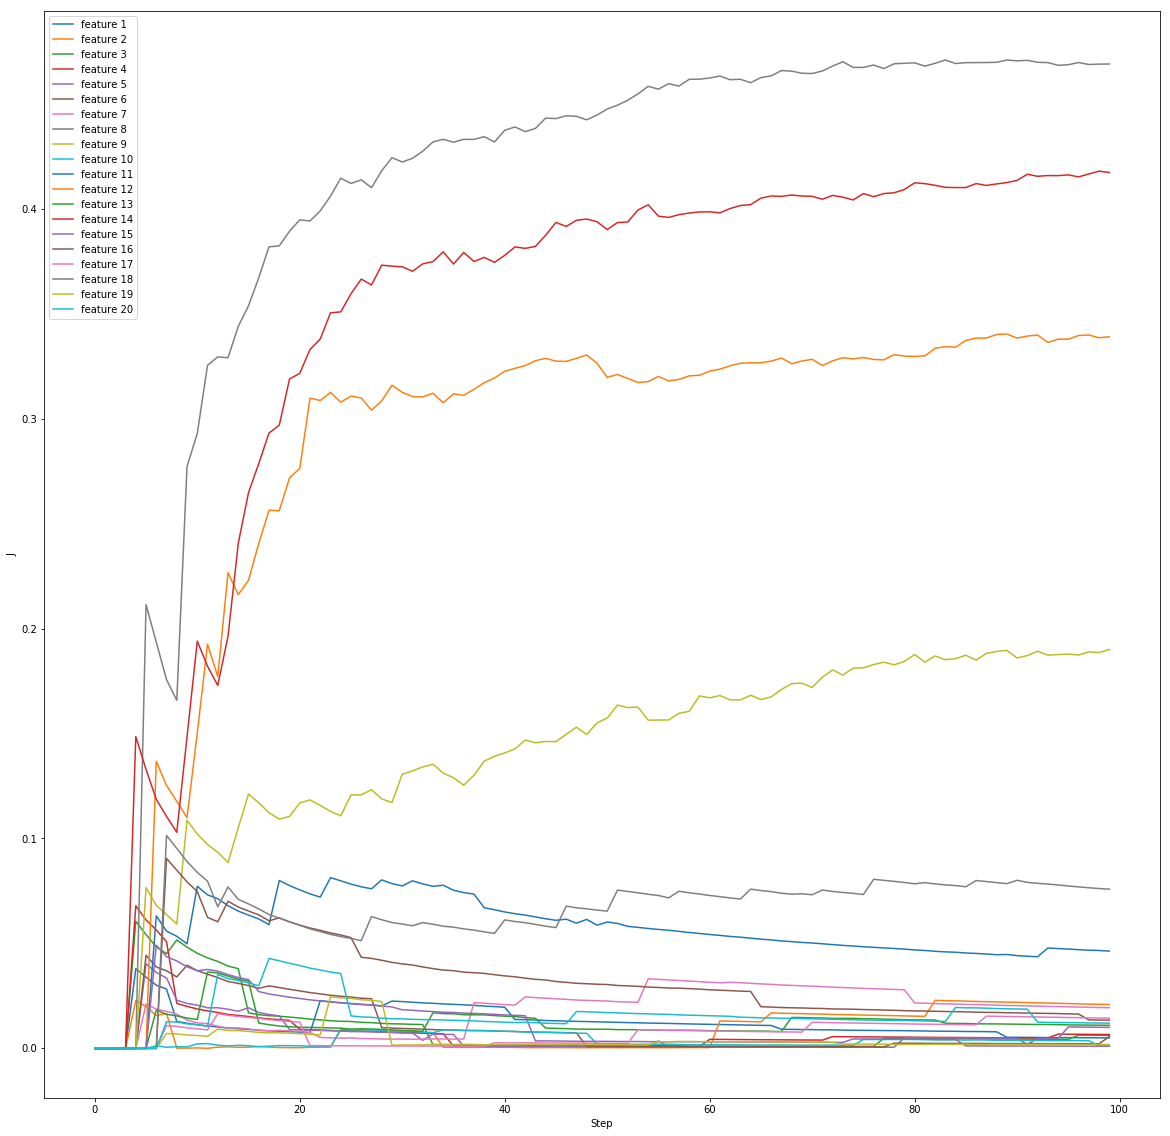

In [25]:
plot_J(J_rec_1)

Reset collected data for next approach:

In [18]:
dataset.reset_collection()

Approach 2: J is computed using collected data in memory only

In [19]:
reg_2 = initialize_regressor(dataset._n_features)
J_2, reg_2, J_rec_2 = simulate_procedure(dataset,reg_2,estimation=False)

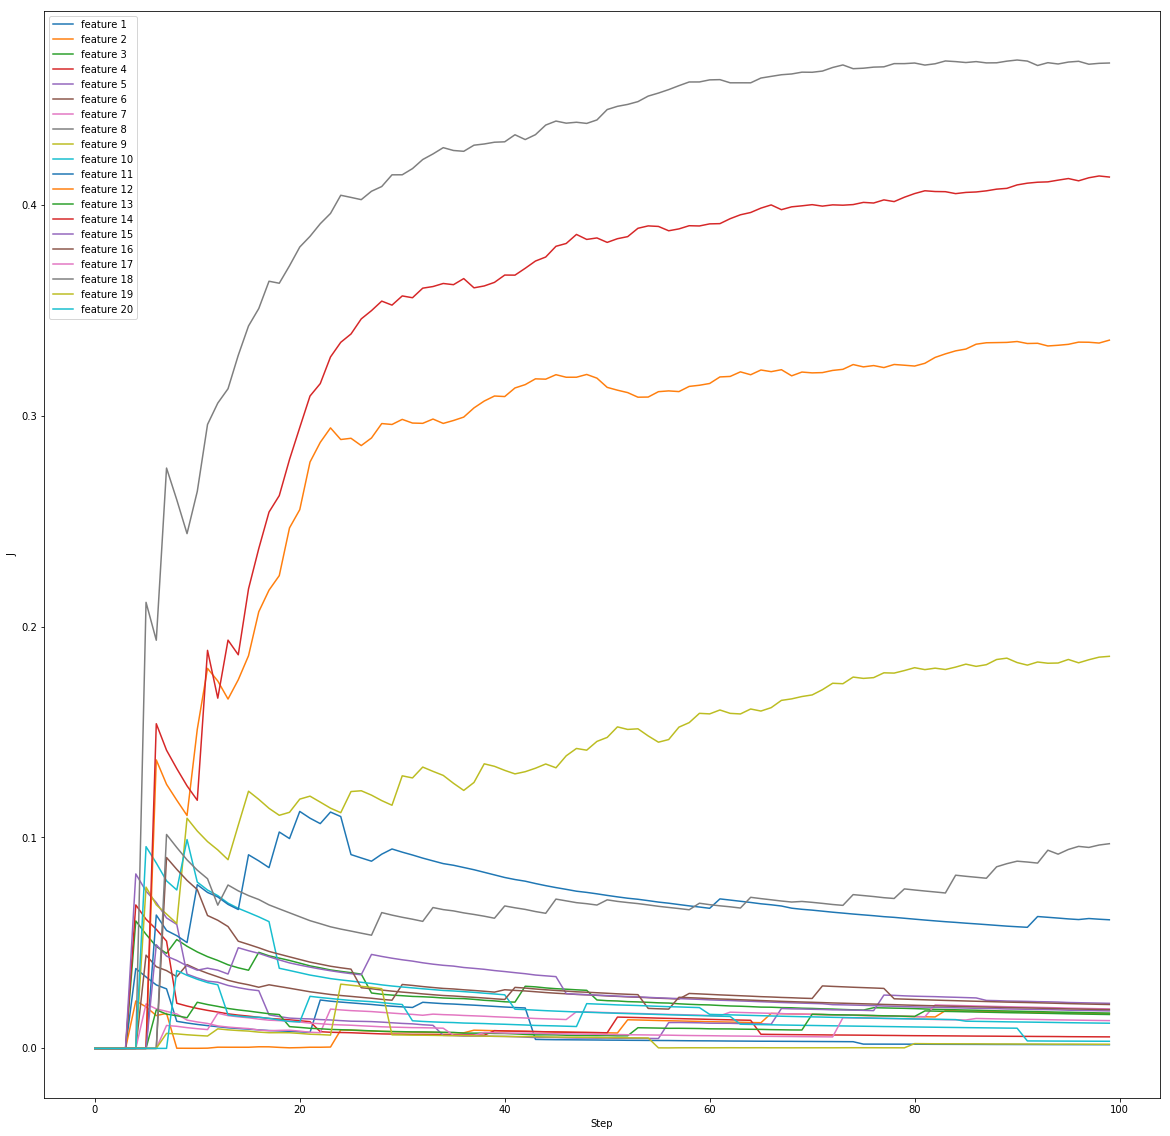

In [20]:
plot_J(J_rec_2)

Following code provides the correlation vector using the entire dataset, and the actual model that is used to generate the data.

In [21]:
corr_vec = get_correlation_vec(dataset._X,dataset._y)
print("Correlation vector obtained using entire dataset:")
print("================================")
print(corr_vec)

Correlation vector obtained using entire dataset:
labels        1.000000
feature 8     0.477120
feature 14    0.432780
feature 12    0.364725
feature 9     0.225948
feature 18    0.197710
feature 11    0.148029
feature 7     0.084099
feature 4     0.069190
feature 5     0.048090
feature 13    0.035103
feature 10    0.025610
feature 19    0.013085
feature 1     0.006432
feature 15   -0.000910
feature 16   -0.012616
feature 3    -0.012940
feature 17   -0.015724
feature 2    -0.032948
feature 6    -0.037144
feature 20   -0.056796
Name: labels, dtype: float64


Following code provides the actual model (with rounded coefficients) that the dataset is based on.

In [22]:
actual_model = dataset._model
print("Actual model of the system:")
print("================================")
feature = 1
model_eq = "y(x) ~="
for coef in actual_model:
    if coef != 0:
        model_eq += " {:.2f} x_{} +".format(coef,feature)
    feature += 1
if model_eq[-1] == "+":
    actual_model_eq = model_eq[:-1]
print(actual_model_eq)

Actual model of the system:
y(x) ~= 18.07 x_5 + 9.22 x_7 + 91.16 x_8 + 45.66 x_9 + 26.40 x_11 + 76.04 x_12 + 80.44 x_14 + 28.53 x_18 


Following code provides the model (with rounded coefficients) obtained from Approach 1.

In [23]:
model_1 = reg_1.coef_[0]
print("Model obtained from Approach 1:")
print("================================")
feature = 1
model_eq = "y(x) ~="
for coef in model_1:
    if coef != 0:
        model_eq += " {:.2f} x_{} +".format(coef,feature)
    feature += 1
if model_eq[-1] == "+":
    model_1_eq = model_eq[:-1]
print(model_1_eq)

Model obtained from Approach 1:
y(x) ~= 2.69 x_1 + -1.79 x_2 + -7.70 x_3 + -9.20 x_4 + 12.51 x_5 + 5.09 x_6 + 8.19 x_7 + 92.13 x_8 + 42.88 x_9 + -3.68 x_10 + 32.43 x_11 + 77.02 x_12 + 11.31 x_13 + 78.18 x_14 + -3.39 x_15 + -7.21 x_16 + -2.02 x_17 + 26.47 x_18 + -0.03 x_19 + -4.97 x_20 


Following code provides the model (with rounded coefficients) obtained from Approach 2.

In [24]:
model_2 = reg_2.coef_[0]
print("Model obtained from Approach 2:")
print("================================")
feature = 1
model_eq = "y(x) ~="
for coef in model_2:
    if coef != 0:
        model_eq += " {:.2f} x_{} +".format(coef,feature)
    feature += 1
if model_eq[-1] == "+":
    model_2_eq = model_eq[:-1]
print(model_2_eq)

Model obtained from Approach 2:
y(x) ~= 0.73 x_1 + 3.11 x_2 + -5.31 x_3 + -0.58 x_4 + 17.91 x_5 + -1.99 x_6 + 7.39 x_7 + 92.37 x_8 + 42.80 x_9 + -8.36 x_10 + 31.01 x_11 + 76.03 x_12 + -7.00 x_13 + 78.45 x_14 + -7.12 x_15 + -6.38 x_16 + -7.83 x_17 + 29.89 x_18 + 0.27 x_19 + -3.37 x_20 
